# Skin Tone Classification Testing Notebook

This notebook is designed for **testing** the skin tone classification model.

To run the default tests, simply **run all cells**.

---

## Testing with Your Own Image

If you want to test with a custom image:

1.  **Upload** your desired image to this notebook's environment.
2.  Update the `test_image_path` argument in the `predict_and_show` function call to the file path of your uploaded image.

In [1]:
#import libraries
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [2]:
#download dataset
import kagglehub

path = kagglehub.dataset_download("adityakammati/skintone-dataset")

print("Path to dataset files:", path)

100%|██████████| 71.5M/71.5M [00:02<00:00, 31.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityakammati/skintone-dataset/versions/1


In [3]:
# Check dataset folder structure, classes, and image counts for each split
DATASET_PATH = path

train_path = os.path.join(DATASET_PATH, "train")
val_path = os.path.join(DATASET_PATH, "valid")
test_path = os.path.join(DATASET_PATH, "test")

print("Train classes:", os.listdir(train_path))
print("Validation classes:", os.listdir(val_path))
print("Test classes:", os.listdir(test_path))

for split, path in [("Train", train_path), ("Validation", val_path), ("Test", test_path)]:
    total_images = sum(len(files) for _, _, files in os.walk(path))
    print(f"{split} images:", total_images)

Train classes: ['light', 'fair', 'dark']
Validation classes: ['light', 'fair', 'dark']
Test classes: ['light', 'fair', 'dark']
Train images: 1470
Validation images: 420
Test images: 210


In [4]:
# Prepare image generators with preprocessing and augmentation
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

# Load images from directories and create train, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Display number of classes and their labels
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)
print("Class indices:", train_generator.class_indices)

Found 1470 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Number of classes: 3
Class indices: {'dark': 0, 'fair': 1, 'light': 2}


In [5]:
model_path = kagglehub.model_download("adityakammati/skintone-images-model/keras/default")
model_file = os.path.join(model_path, "efficientnet_finetuned_v5.keras")

print("Path to model files:", model_path)


  0%|          | 0.00/44.3M [00:00<?, ?B/s]
  2%|▏         | 1.00M/44.3M [00:00<00:25, 1.76MB/s]
  5%|▍         | 2.00M/44.3M [00:00<00:13, 3.40MB/s]
  9%|▉         | 4.00M/44.3M [00:00<00:05, 7.12MB/s]
 18%|█▊        | 8.00M/44.3M [00:00<00:02, 15.0MB/s]
 27%|██▋       | 12.0M/44.3M [00:01<00:01, 20.9MB/s]
 36%|███▌      | 16.0M/44.3M [00:01<00:01, 25.9MB/s]
 45%|████▌     | 20.0M/44.3M [00:01<00:00, 27.7MB/s]
 54%|█████▍    | 24.0M/44.3M [00:01<00:00, 24.0MB/s]
 63%|██████▎   | 28.0M/44.3M [00:01<00:00, 27.1MB/s]
 72%|███████▏  | 32.0M/44.3M [00:01<00:00, 30.5MB/s]
 81%|████████▏ | 36.0M/44.3M [00:01<00:00, 33.2MB/s]
 90%|█████████ | 40.0M/44.3M [00:01<00:00, 35.3MB/s]
100%|██████████| 44.3M/44.3M [00:02<00:00, 22.6MB/s]

Path to model files: /root/.cache/kagglehub/models/adityakammati/skintone-images-model/keras/default/1


In [6]:
model = load_model(model_file)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8694 - loss: 0.2652
Test Accuracy: 0.7905


In [9]:
test_path = os.path.join(DATASET_PATH, "test")
first_class = sorted(os.listdir(test_path))[0]
first_image = sorted(os.listdir(os.path.join(test_path, first_class)))[0]
test_image_path = "/content/1900x1267-v1.jpg"

print("First test image path:", test_image_path)

First test image path: /content/1900x1267-v1.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


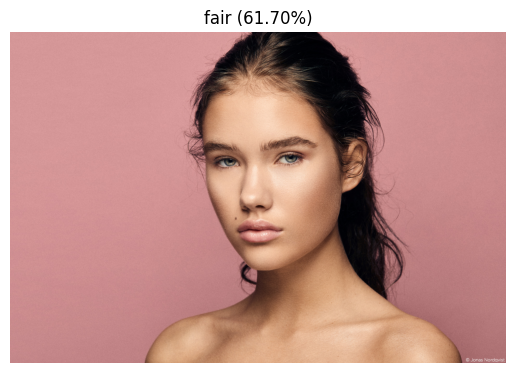

Predicted: fair  (Confidence: 0.62)


('fair', 0.6170151233673096)

In [10]:
def predict_and_show(img_path, model, target_size=(224, 224), class_labels=None):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_array_exp = efficientnet_preprocess(img_array_exp)

    preds = model.predict(img_array_exp)
    predicted_idx = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    if class_labels:
        class_list = list(class_labels)
        predicted_class = class_list[predicted_idx]
    else:
        predicted_class = str(predicted_idx)

    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence*100:.2f}%)")
    plt.show()

    print(f"Predicted: {predicted_class}  (Confidence: {confidence:.2f})")
    return predicted_class, confidence


# Example usage
class_labels = list(train_generator.class_indices.keys())
predict_and_show(test_image_path, model, target_size=(224, 224), class_labels=class_labels)